Further clean some columns and focus on
consumption-for-eg-btu >>>> electricity generation | ash-content | heat-content

In [172]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sqlalchemy import create_engine

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
db = '../static/data/eia_electric.sqlite'

In [179]:
engine = create_engine(f'sqlite:///{db}')
conn = engine.connect()

In [180]:
data = pd.read_sql('SELECT * FROM epo', conn, parse_dates = ['period'])
data.head()

,period,energySource,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
0,2008-01-01,fossil fuels,308.89,3734358.85,27878.91,594559.14,1025.72,4477.05,692.55,2854188.91,974.95,4011940.29,26408984.47,2367212.11,81.48,4328918.00,28904.63
1,2008-01-01,others,0.00,2666.20,2263.20,12391.55,7.95,0.00,0.00,214662.90,0.00,0.00,0.00,0.00,0.00,15057.75,2271.15
2,2008-01-01,renewables,254.19,51894.93,1381.14,4114.64,453.03,591.66,101.83,126059.98,101.13,4074.26,44771.59,7392.34,8.36,56009.57,1834.17
3,2008-02-01,fossil fuels,169.75,1476772.66,10823.13,321531.26,499.01,2371.16,374.65,1092655.81,617.48,1660658.05,10715695.93,1002393.72,64.86,1798303.92,11322.14
4,2008-02-01,others,0.00,913.06,13.82,8851.58,3.47,0.00,0.00,1004.15,0.00,0.00,0.00,0.00,0.00,9764.64,17.29


In [181]:
engine.dispose()

In [182]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   period                  539 non-null    datetime64[ns]
 1   energySource            539 non-null    object        
 2   ash-content             539 non-null    float64       
 3   consumption-for-eg      539 non-null    float64       
 4   consumption-for-eg-btu  539 non-null    float64       
 5   consumption-uto         539 non-null    float64       
 6   consumption-uto-btu     539 non-null    float64       
 7   cost                    539 non-null    float64       
 8   cost-per-btu            539 non-null    float64       
 9   generation              539 non-null    float64       
 10  heat-content            539 non-null    float64       
 11  receipts                539 non-null    float64       
 12  receipts-btu            539 non-null    float64   

In [184]:
data.describe()

,period,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
count,539,539.000000,5.390000e+02,539.000000,539.000000,539.000000,539.000000,539.000000,5.390000e+02,539.000000,5.390000e+02,5.390000e+02,5.390000e+02,539.000000,5.390000e+02,539.000000
mean,2015-06-13 00:58:46.530612224,91.986030,8.858754e+05,3967.218998,113223.819685,231.694082,600.468905,82.841336,4.280473e+05,246.539258,8.558034e+05,3.106432e+06,2.438369e+05,19.361354,9.992302e+05,4198.913135
min,2008-01-01 00:00:00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,2011-09-16 00:00:00,0.000000,2.488380e+03,948.415000,822.205000,4.995000,0.000000,0.000000,9.362144e+04,52.615000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,5.212675e+03,1023.150000
50%,2015-06-01 00:00:00,78.410000,9.381069e+04,1790.790000,15942.150000,179.080000,41.500000,3.330000,1.860718e+05,113.550000,1.051180e+03,1.224471e+04,1.372160e+03,3.740000,1.094533e+05,1970.550000
75%,2019-03-01 00:00:00,155.365000,1.267921e+06,4721.825000,149647.160000,396.885000,794.165000,115.065000,5.558912e+05,378.995000,1.267895e+06,4.647997e+06,3.149079e+05,33.735000,1.534678e+06,5104.835000
max,2022-12-01 00:00:00,468.930000,8.481988e+06,28266.020000,914975.860000,1110.850000,6373.860000,1002.720000,2.962540e+06,1148.580000,8.274031e+06,3.082787e+07,2.670282e+06,139.610000,9.162980e+06,29291.750000
std,NaN,94.445102,1.539172e+06,5048.938257,187679.520475,242.430036,1039.294813,145.828223,5.421836e+05,280.602127,1.561441e+06,5.573904e+06,4.743394e+05,28.578948,1.700005e+06,5228.480098


In [200]:
# Create DF of each energySource
ff_df = data.loc[data['energySource'] == 'fossil fuels'].drop(columns = ['energySource', 'consumption-for-eg', 'consumption-uto', 'cost', 'receipts', 'total-consumption']).reset_index(drop = True)
re_df = data.loc[data['energySource'] == 'renewables'].drop(columns = ['energySource', 'consumption-for-eg', 'consumption-uto', 'cost', 'receipts', 'total-consumption']).reset_index(drop = True)
oth_df = data.loc[data['energySource'] == 'others'].drop(columns = ['energySource', 'consumption-for-eg', 'consumption-uto', 'cost', 'receipts', 'total-consumption']).reset_index(drop = True)

In [201]:
# View the DF
display(ff_df.head())
display(re_df.head())
display(oth_df.head())

,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
0,2008-01-01,308.89,27878.91,1025.72,692.55,2854188.91,974.95,26408984.47,2367212.11,81.48,28904.63
1,2008-02-01,169.75,10823.13,499.01,374.65,1092655.81,617.48,10715695.93,1002393.72,64.86,11322.14
2,2008-03-01,186.00,18790.52,517.57,430.28,1896707.59,636.02,19884252.94,1688695.23,57.80,19308.09
3,2008-04-01,141.35,3568.69,365.29,467.37,389797.38,597.83,4269570.66,383229.39,57.73,3933.97
4,2008-05-01,292.46,20102.26,613.08,811.72,2047455.12,859.70,22080016.66,1857521.77,81.20,20715.35


,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
0,2008-01-01,254.19,1381.14,453.03,101.83,126059.98,101.13,44771.59,7392.34,8.36,1834.17
1,2008-02-01,84.50,984.17,286.58,10.15,92283.99,26.48,5661.45,0.31,2.22,1270.75
2,2008-03-01,121.44,1096.70,275.74,48.14,97623.18,57.18,19221.36,2269.99,7.06,1372.43
3,2008-04-01,183.17,955.16,111.66,53.69,88211.84,63.21,38998.03,3663.94,8.07,1066.82
4,2008-05-01,192.42,2110.28,514.37,69.25,204628.12,82.69,22865.65,2210.53,7.72,2624.66


,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
0,2008-01-01,0.0,2263.20,7.95,0.0,214662.90,0.0,0.0,0.0,0.0,2271.15
1,2008-02-01,0.0,13.82,3.47,0.0,1004.15,0.0,0.0,0.0,0.0,17.29
2,2008-03-01,0.0,364.76,4.11,0.0,34789.20,0.0,0.0,0.0,0.0,368.87
3,2008-04-01,0.0,1476.02,1.46,0.0,140679.82,0.0,0.0,0.0,0.0,1477.48
4,2008-05-01,0.0,2067.83,3.84,0.0,196224.27,0.0,0.0,0.0,0.0,2071.67


In [202]:
# Check dType for one to verify the data types are correct
ff_df.dtypes

period                    datetime64[ns]
ash-content                      float64
consumption-for-eg-btu           float64
consumption-uto-btu              float64
cost-per-btu                     float64
generation                       float64
heat-content                     float64
receipts-btu                     float64
stocks                           float64
sulfur-content                   float64
total-consumption-btu            float64
dtype: object

In [207]:
# Display the DFs' correlation using .corr()
display(ff_df.corr())
display(re_df.corr())
display(oth_df.corr())

,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,1.000000,-0.285271,-0.340669,-0.041666,-0.160245,-0.275801,-0.189559,-0.374007,-0.300310,-0.320387,-0.333319
ash-content,-0.285271,1.000000,0.780160,0.652910,0.568916,0.779752,0.900720,0.797011,0.601401,0.875264,0.786267
consumption-for-eg-btu,-0.340669,0.780160,1.000000,0.634359,0.584082,0.996106,0.721594,0.987912,0.751089,0.703993,0.999494
consumption-uto-btu,-0.041666,0.652910,0.634359,1.000000,0.492494,0.657586,0.689162,0.639594,0.529336,0.572249,0.658627
cost-per-btu,-0.160245,0.568916,0.584082,0.492494,1.000000,0.587397,0.650595,0.591748,0.647252,0.495924,0.588805
generation,-0.275801,0.779752,0.996106,0.657586,0.587397,1.000000,0.729942,0.981903,0.743432,0.704991,0.996660
heat-content,-0.189559,0.900720,0.721594,0.689162,0.650595,0.729942,1.000000,0.729080,0.641788,0.896841,0.730750
receipts-btu,-0.374007,0.797011,0.987912,0.639594,0.591748,0.981903,0.729080,1.000000,0.781560,0.711073,0.987943
stocks,-0.300310,0.601401,0.751089,0.529336,0.647252,0.743432,0.641788,0.781560,1.000000,0.502258,0.752884
sulfur-content,-0.320387,0.875264,0.703993,0.572249,0.495924,0.704991,0.896841,0.711073,0.502258,1.000000,0.708808


,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,1.000000,-0.352078,0.170796,-0.128622,-0.628406,0.413223,0.133318,-0.485020,-0.198970,-0.444762,0.140434
ash-content,-0.352078,1.000000,0.499586,0.510958,0.445759,0.409188,0.560768,0.832934,0.517218,0.893683,0.530392
consumption-for-eg-btu,0.170796,0.499586,1.000000,0.515768,0.078042,0.877308,0.569893,0.405346,0.430022,0.487869,0.993307
consumption-uto-btu,-0.128622,0.510958,0.515768,1.000000,0.288136,0.458096,0.513922,0.426101,0.406879,0.428189,0.611275
cost-per-btu,-0.628406,0.445759,0.078042,0.288136,1.000000,-0.047972,-0.038887,0.565113,0.679230,0.550797,0.110941
generation,0.413223,0.409188,0.877308,0.458096,-0.047972,1.000000,0.575463,0.290586,0.386599,0.360788,0.872192
heat-content,0.133318,0.560768,0.569893,0.513922,-0.038887,0.575463,1.000000,0.316951,0.185938,0.467850,0.595738
receipts-btu,-0.485020,0.832934,0.405346,0.426101,0.565113,0.290586,0.316951,1.000000,0.560780,0.896413,0.431895
stocks,-0.198970,0.517218,0.430022,0.406879,0.679230,0.386599,0.185938,0.560780,1.000000,0.557965,0.452099
sulfur-content,-0.444762,0.893683,0.487869,0.428189,0.550797,0.360788,0.467850,0.896413,0.557965,1.000000,0.508408


,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,1.000000,NaN,-0.169488,-0.218991,NaN,-0.167996,0.394901,NaN,NaN,NaN,-0.170020
ash-content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
consumption-for-eg-btu,-0.169488,NaN,1.000000,0.387082,NaN,0.999985,0.146605,NaN,NaN,NaN,0.999995
consumption-uto-btu,-0.218991,NaN,0.387082,1.000000,NaN,0.384839,0.156582,NaN,NaN,NaN,0.390028
cost-per-btu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation,-0.167996,NaN,0.999985,0.384839,NaN,1.000000,0.146231,NaN,NaN,NaN,0.999972
heat-content,0.394901,NaN,0.146605,0.156582,NaN,0.146231,1.000000,NaN,NaN,NaN,0.146950
receipts-btu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stocks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sulfur-content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
# Check the shapes of our DFs
print(ff_df.shape, re_df.shape, oth_df.shape)

(180, 11) (180, 11) (179, 11)


# FUNCTIONS

In [185]:
def set_scale_df(df, start_pos, end_pos, set_index):
    '''
        Function to scale the data to help reduce biases as part of preprocessing by using MinMaxScaler.
        This is to account for the outliers.
    '''
    cols = list(df)[start_pos:end_pos]
    train_df = df[cols]

    scaler = MinMaxScaler()
    scaler = scaler.fit(train_df)
    
    train_scaled_df = scaler.transform(train_df)
    train_scaled_df = pd.DataFrame(train_scaled_df, columns = cols)
    
    train_scaled_df[set_index] = df[[set_index]]
    train_scaled_df = train_scaled_df.set_index(set_index)
    
    return train_scaled_df

def plot_feature(df, nrows = 1, ncols = 1):
    '''Function to plot the features in a dataframe with time being the index value'''
    fig_ff, axes_ff = plt.subplots(nrows = nrows, ncols = ncols, dpi = 120)
    
    for i, ax in enumerate(axes_ff.flatten()):
        data = df[df.columns[i]]

        ax.plot(data, color = 'red', linewidth = 1)
        ax.set_title(ff_df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize = 6)

    plt.tight_layout()

def print_ADF(df):
    '''Function to verify which features in the DF is stationary or nonstationary'''
    cols = list(df)
    ideal_features = []
    
    for col in cols:
        try:
            ad_fuller_result = adfuller(df[col])

            print(f'real {col}')        

            if ad_fuller_result[1] < 0.05:
                print(f'ADF Statistic: {ad_fuller_result[0]}')
                print(f'p-value: {ad_fuller_result[1]}')
                ideal_features.append(col)
            else:
                print(f'p-value: {ad_fuller_result[1]} ==> Non-stationary')
        except:
            print(col) 
            print('Failed to run the ADF test')
        print('-' * 10)
    
    print('Stationary features:', ideal_features)

In [191]:
list(ff_train_scaled_df)

['ash-content',
 'consumption-for-eg',
 'consumption-for-eg-btu',
 'consumption-uto',
 'consumption-uto-btu',
 'cost',
 'cost-per-btu',
 'generation',
 'heat-content',
 'receipts',
 'receipts-btu',
 'stocks',
 'sulfur-content',
 'total-consumption',
 'total-consumption-btu']

In [209]:
# Scale the features
ff_train_scaled_df = set_scale_df(ff_df, 1, len(ff_df.columns) + 1, 'period')
re_train_scaled_df = set_scale_df(re_df, 1, len(re_df.columns) + 1, 'period')
oth_train_scaled_df = set_scale_df(oth_df, 1, len(oth_df.columns) + 1, 'period')

In [210]:
# Preview 5 rows of the scaled data
display(ff_train_scaled_df)
display(re_train_scaled_df)
display(oth_train_scaled_df)

,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,,,,,,,,,,
2008-01-01,0.658712,0.986305,0.923365,0.690671,0.963426,0.848831,0.856660,0.886503,0.583626,0.986784
2008-02-01,0.361994,0.382903,0.449215,0.373634,0.368824,0.537603,0.347598,0.375389,0.464580,0.386530
2008-03-01,0.396648,0.664774,0.465922,0.429113,0.640230,0.553745,0.645009,0.632403,0.414010,0.659165
2008-04-01,0.301431,0.126254,0.328838,0.466102,0.131575,0.520495,0.138497,0.143516,0.413509,0.134303
2008-05-01,0.623675,0.711181,0.551902,0.809518,0.691115,0.748489,0.716236,0.695628,0.581620,0.707208
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.432730,0.578347,0.698186,0.564475,0.644983,0.630021,0.511380,0.255892,0.417663,0.584572
2022-09-01,0.428721,0.126510,0.306702,0.213449,0.154358,0.340333,0.117551,0.021502,0.362008,0.133711
2022-10-01,0.420724,0.309997,0.305055,0.427996,0.348934,0.517500,0.321694,0.246608,0.469307,0.310711


,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,,,,,,,,,,
2008-01-01,0.942247,0.285264,0.629978,0.783850,0.169608,0.338675,0.740023,0.924657,0.633813,0.329857
2008-02-01,0.313230,0.203242,0.398515,0.078131,0.124157,0.076358,0.093577,0.000039,0.168309,0.228503
2008-03-01,0.450161,0.226493,0.383441,0.370564,0.131342,0.184236,0.317707,0.283938,0.535254,0.246794
2008-04-01,0.678986,0.197248,0.155273,0.413286,0.118677,0.205426,0.644593,0.458297,0.611827,0.191818
2008-05-01,0.713274,0.435919,0.715277,0.533061,0.275335,0.273877,0.377943,0.276500,0.585292,0.472059
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.202209,0.272416,0.439704,0.028250,0.499176,0.613360,0.128071,0.114783,0.139500,0.294055
2022-09-01,0.000000,0.029483,0.202956,0.000000,0.021867,0.302375,0.000000,0.070549,0.000000,0.051922
2022-10-01,0.000000,0.110982,0.590166,0.000000,0.161399,0.453124,0.000000,0.055314,0.000000,0.172972


,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,,,,,,,,,,
2008-01-01,0.0,0.740793,0.552467,0.0,0.740046,0.000000,0.0,0.0,0.0,0.741928
2008-02-01,0.0,0.004436,0.241140,0.0,0.003348,0.000000,0.0,0.0,0.0,0.005317
2008-03-01,0.0,0.119319,0.285615,0.0,0.119840,0.000000,0.0,0.0,0.0,0.120221
2008-04-01,0.0,0.483102,0.101459,0.0,0.484952,0.000000,0.0,0.0,0.0,0.482540
2008-05-01,0.0,0.676837,0.266852,0.0,0.676470,0.000000,0.0,0.0,0.0,0.676734
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.0,0.715416,0.362057,0.0,0.718715,0.369067,0.0,0.0,0.0,0.715701
2022-09-01,0.0,0.001532,0.000000,0.0,0.000757,0.120153,0.0,0.0,0.0,0.001284
2022-10-01,0.0,0.317926,0.336345,0.0,0.318655,0.372305,0.0,0.0,0.0,0.318740


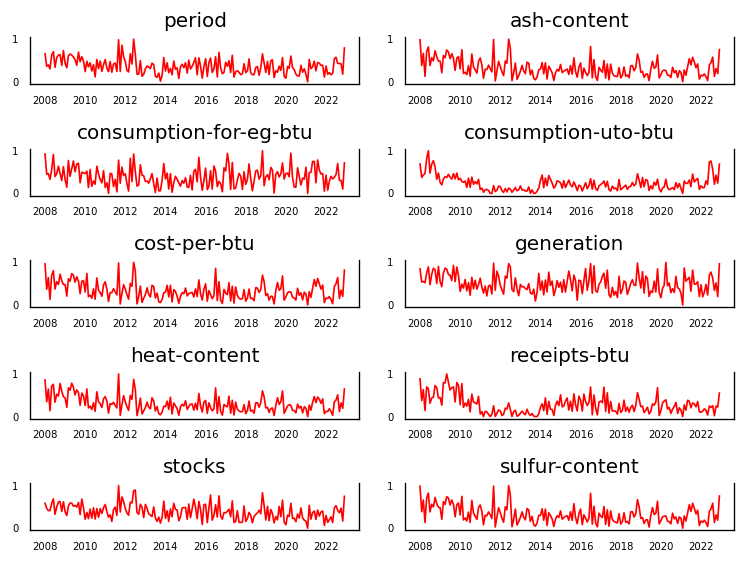

In [212]:
# Plot ff_train_scaled_df's features
plot_feature(ff_train_scaled_df, 5, 2)

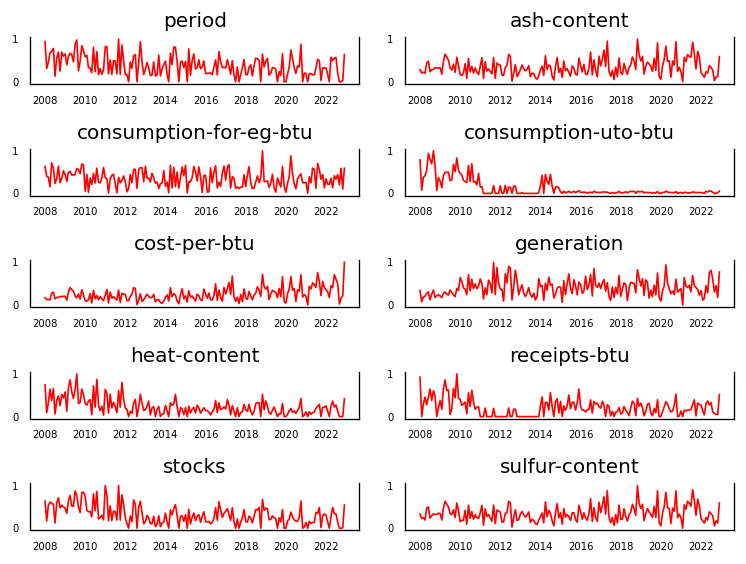

In [213]:
# Plot re_train_scaled_df
plot_feature(re_train_scaled_df, 5, 2)

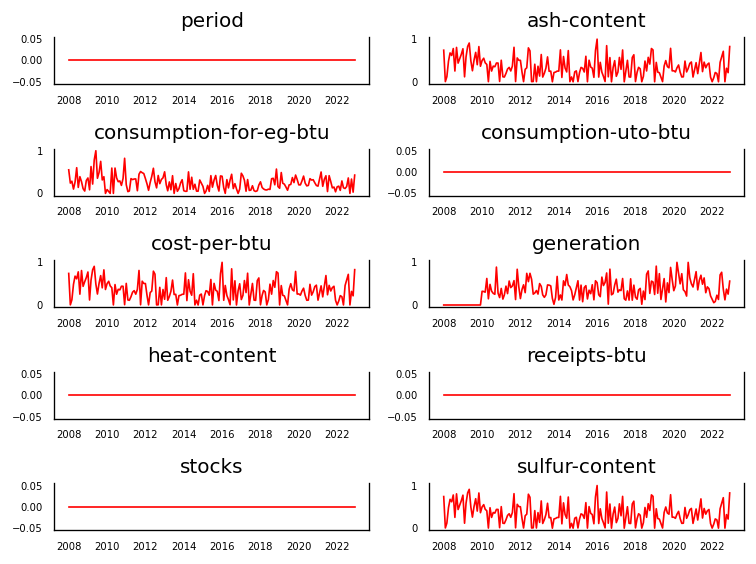

In [214]:
# Plot oth_train_scaled_df's features
plot_feature(oth_train_scaled_df, 5, 2)

### Augmented DIckey-Fuller Test
---
The following features that are best kept so that we may use one model for all energy type are:
* `generation`, `consumption-for-eg`, `consumption-for-eg-btu`, `consumption-uto-btu`, `heat-content`, `total-consumption-btu`

In [215]:
# ADF - Augmented Dickey-Fuller test for ff_train_scaled_df
print_ADF(ff_train_scaled_df)

real ash-content
ADF Statistic: -5.437392159469737
p-value: 2.8255771799710924e-06
----------
real consumption-for-eg-btu
ADF Statistic: -6.943491983192342
p-value: 1.0109827253411431e-09
----------
real consumption-uto-btu
ADF Statistic: -13.977232410123982
p-value: 4.240130542764968e-26
----------
real cost-per-btu
ADF Statistic: -3.8403964061692615
p-value: 0.002520020298564862
----------
real generation
ADF Statistic: -7.208867084403546
p-value: 2.2622860291068296e-10
----------
real heat-content
ADF Statistic: -7.759312860655456
p-value: 9.548693620678973e-12
----------
real receipts-btu
ADF Statistic: -5.157139997462318
p-value: 1.0747647597152416e-05
----------
real stocks
p-value: 0.089610715540137 ==> Non-stationary
----------
real sulfur-content
ADF Statistic: -2.9471893795869333
p-value: 0.04012929313786442
----------
real total-consumption-btu
ADF Statistic: -6.999192082615318
p-value: 7.397296844422221e-10
----------
Stationary features: ['ash-content', 'consumption-for-eg

In [216]:
# ADF - Augmented Dickey-Fuller test for re_train_scaled_df
print_ADF(re_train_scaled_df)

real ash-content
p-value: 0.2115922343349112 ==> Non-stationary
----------
real consumption-for-eg-btu
ADF Statistic: -7.5668371342062635
p-value: 2.910631468622283e-11
----------
real consumption-uto-btu
ADF Statistic: -13.46133268583789
p-value: 3.525127447512679e-25
----------
real cost-per-btu
p-value: 0.22432934052886638 ==> Non-stationary
----------
real generation
p-value: 0.6953398336174812 ==> Non-stationary
----------
real heat-content
ADF Statistic: -12.662287254261273
p-value: 1.2970877760835431e-23
----------
real receipts-btu
p-value: 0.3164607853574115 ==> Non-stationary
----------
real stocks
p-value: 0.08020247720551693 ==> Non-stationary
----------
real sulfur-content
p-value: 0.1673424856289331 ==> Non-stationary
----------
real total-consumption-btu
ADF Statistic: -7.779866070153964
p-value: 8.473750109476657e-12
----------
Stationary features: ['consumption-for-eg-btu', 'consumption-uto-btu', 'heat-content', 'total-consumption-btu']


In [217]:
# ADF - Augmented Dickey-Fuller test for oth_train_scaled_df
print_ADF(oth_train_scaled_df)

ash-content
Failed to run the ADF test
----------
real consumption-for-eg-btu
ADF Statistic: -13.098877521749932
p-value: 1.7263942671522416e-24
----------
real consumption-uto-btu
ADF Statistic: -7.526759360290672
p-value: 3.6674090611265124e-11
----------
cost-per-btu
Failed to run the ADF test
----------
real generation
ADF Statistic: -13.117978422483944
p-value: 1.5845903711682913e-24
----------
real heat-content
ADF Statistic: -3.399493963959537
p-value: 0.010976134442620791
----------
receipts-btu
Failed to run the ADF test
----------
stocks
Failed to run the ADF test
----------
sulfur-content
Failed to run the ADF test
----------
real total-consumption-btu
ADF Statistic: -13.094225851159658
p-value: 1.762865576763407e-24
----------
Stationary features: ['consumption-for-eg-btu', 'consumption-uto-btu', 'generation', 'heat-content', 'total-consumption-btu']


In [223]:
ff_data = ff_train_scaled_df[[
    'consumption-for-eg-btu', 'generation'
]]
ff_data.shape

(180, 2)

In [224]:
train_ff_df = ff_data[ : round(ff_data.shape[0] * 0.75)]
test_ff_df = ff_data[round(ff_data.shape[0] * 0.75) : ]

In [225]:
print(train_ff_df.shape, test_ff_df.shape)

(135, 2) (45, 2)


In [226]:
model = VAR(train_ff_df)

sorted_order =model.select_order(maxlags = 15)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.84      -11.79   7.209e-06      -11.82
1       -11.96     -11.82*   6.399e-06      -11.90
2       -12.00      -11.77   6.132e-06      -11.91
3      -12.08*      -11.75  5.676e-06*     -11.95*
4       -12.02      -11.61   6.004e-06      -11.85
5       -11.97      -11.46   6.313e-06      -11.77
6       -11.98      -11.38   6.278e-06      -11.73
7       -11.95      -11.25   6.471e-06      -11.67
8       -11.93      -11.14   6.597e-06      -11.61
9       -11.89      -11.01   6.878e-06      -11.53
10      -11.86      -10.89   7.115e-06      -11.46
11      -11.81      -10.74   7.493e-06      -11.38
12      -11.79      -10.63   7.666e-06      -11.32
13      -11.79      -10.54   7.674e-06      -11.28
14      -11.74      -10.39   8.118e-06      -11.19
15      -11.69      -10.25   8.599e-06      -11.10
-------------------------------

In [227]:
var_model = VARMAX(train_ff_df, order = (3, 0), enforce_stationarity = True)
fitted_model = var_model.fit(disp = False)
print(fitted_model.summary())

                                      Statespace Model Results                                      
Dep. Variable:     ['consumption-for-eg-btu', 'generation']   No. Observations:                  135
Model:                                               VAR(3)   Log Likelihood                 442.747
                                                + intercept   AIC                           -851.494
Date:                                      Thu, 08 Feb 2024   BIC                           -802.104
Time:                                              18:20:14   HQIC                          -831.424
Sample:                                          01-01-2008                                         
                                               - 03-01-2019                                         
Covariance Type:                                        opg                                         
Ljung-Box (L1) (Q):             0.06, 0.03   Jarque-Bera (JB):          18.17, 6.24
Prob(Q)

In [138]:
re_train_scaled_df.corr()

,ash-content,consumption-for-eg,consumption-for-eg-btu,consumption-uto,consumption-uto-btu,cost,cost-per-btu,generation,heat-content,receipts,receipts-btu,stocks,sulfur-content,total-consumption,total-consumption-btu
ash-content,1.000000,0.426812,0.499586,0.266126,0.510958,0.488130,0.445759,0.409188,0.560768,0.830281,0.832934,0.517218,0.893683,0.422576,0.530392
consumption-for-eg,0.426812,1.000000,0.800892,0.629473,0.564762,0.003392,-0.016136,0.717540,0.669440,0.291804,0.295923,0.288626,0.366383,0.991096,0.815982
consumption-for-eg-btu,0.499586,0.800892,1.000000,0.526736,0.515768,0.107006,0.078042,0.877308,0.569893,0.402412,0.405346,0.430022,0.487869,0.797633,0.993307
consumption-uto,0.266126,0.629473,0.526736,1.000000,0.768418,-0.128533,-0.142158,0.499983,0.599621,0.109121,0.111639,0.124336,0.143719,0.727326,0.590183
consumption-uto-btu,0.510958,0.564762,0.515768,0.768418,1.000000,0.312952,0.288136,0.458096,0.513922,0.433209,0.426101,0.406879,0.428189,0.630489,0.611275
cost,0.488130,0.003392,0.107006,-0.128533,0.312952,1.000000,0.991958,-0.008363,-0.017447,0.613422,0.588673,0.704989,0.582003,-0.019029,0.141043
cost-per-btu,0.445759,-0.016136,0.078042,-0.142158,0.288136,0.991958,1.000000,-0.047972,-0.038887,0.593706,0.565113,0.679230,0.550797,-0.038611,0.110941
generation,0.409188,0.717540,0.877308,0.499983,0.458096,-0.008363,-0.047972,1.000000,0.575463,0.282074,0.290586,0.386599,0.360788,0.719429,0.872192
heat-content,0.560768,0.669440,0.569893,0.599621,0.513922,-0.017447,-0.038887,0.575463,1.000000,0.313582,0.316951,0.185938,0.467850,0.694020,0.595738
receipts,0.830281,0.291804,0.402412,0.109121,0.433209,0.613422,0.593706,0.282074,0.313582,1.000000,0.997042,0.582162,0.894593,0.276430,0.430143
